# Can we split the FOV and assign counts and then put this back together into a PA distribution

In [1]:

import ctypes
import ctypes.util
import os
from optparse import OptionParser
import time
import re

import matplotlib.pyplot as plt
import numpy as np
import spacepy.toolbox as tb
import spacepy.datamodel as dm
import spacepy.pycdf as pycdf
import spacepy.plot as spp

%matplotlib inline



This unreleased version of SpacePy is not supported by the SpacePy team.


/Users/blarsen/miniconda3/envs/python3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


This is the C code that did the cals for all the plots below, it has been changed so I captured it here

In [2]:


# long computePAarb(double rots[3][3],
# 	       double magInterp[3],
# 	       double offset[][2],
# 	       double PA[],
# 	       double PHI[],
# 	       double omega[3],
# 	       long n_values,
# 	       int ROTATION) {

#   double amag, bmag, phi;
#   Lgm_Vector pos, unit;
#   Lgm_Vector a_hat, b_hat, c_hat, omega_vec;
#   long index;
#    double quat1[4], quat_polar[4], quat_az[4], quat_offset[4], quat_final[4];
#     Lgm_Vector vtmp;
#     long count=0;

#   // omega is the spin axis in UVW
#   Lgm_SetVecElements(&omega_vec, omega[0], omega[1], omega[2]);

#   /* Compute PA and Gyro phase in UVW (mag) coordinates.  The natual coordinates for */
#   /*   this are a,b,c.  C is in the direction of magnetic field, a is mag field x spin axis */
#   /*   and b is -axc */

#   Lgm_SetVecElements(&pos, 0,0,0);// this holds the rotated hope look dir in UVW

#   // -1 so that we are in the particle travel direction instead of inst look direction
#   Lgm_SetVecElements(&unit, -1,0,0);// this holds the rotated hope look dir in UVW


#     // TODO !!!!!! TODO
#     // working here, validation

#     Lgm_SetVecElements(&c_hat,
# 			     magInterp[0],
# 			     magInterp[1],
# 			     magInterp[2] );
#         Lgm_NormalizeVector(&c_hat);
#         Lgm_CrossProduct(&c_hat, &omega_vec, &a_hat);

#         Lgm_CrossProduct(&c_hat, &a_hat, &b_hat);


#     for (index=0; index < n_values; index++) {
#         // make the rotation matrix into a quat
#         Lgm_MatrixToQuat(rots, quat1);

#         if (ROTATION==0) { // this is the one I think is right

#             // make a quat for the polar angle, this is about Y (TODO is it?)
#             Lgm_SetVecElements(&vtmp, 0, 1, 0);
#             Lgm_AxisAngleToQuat(&vtmp, offset[index][0], quat_polar);
#             // make a quat for the azi angle, this is about X (TODO is it?)
#             Lgm_SetVecElements(&vtmp, 1, 0, 0);
#             Lgm_AxisAngleToQuat(&vtmp, offset[index][1], quat_az);
#             // combine the quats to get the change on the input matrix
#             Lgm_QuatCombineQuats(quat_polar, quat_az, quat_offset);

#         } else if (ROTATION==1) { // other order on polar, azi rotations

#             // make a quat for the polar angle, this is about Y (TODO is it?)
#             Lgm_SetVecElements(&vtmp, 0, 1, 0);
#             Lgm_AxisAngleToQuat(&vtmp, offset[index][0], quat_polar);
#             // make a quat for the azi angle, this is about X (TODO is it?)
#             Lgm_SetVecElements(&vtmp, 1, 0, 0);
#             Lgm_AxisAngleToQuat(&vtmp, offset[index][1], quat_az);
#             // combine the quats to get the change on the input matrix
#             Lgm_QuatCombineQuats(quat_az,quat_polar, quat_offset);


#         } else if (ROTATION==2) { // Swap azi and Polar

#             // make a quat for the polar angle, this is about X (TODO is it?)
#             Lgm_SetVecElements(&vtmp, 1, 0, 0);
#             Lgm_AxisAngleToQuat(&vtmp, offset[index][0], quat_polar);
#             // make a quat for the azi angle, this is about Y (TODO is it?)
#             Lgm_SetVecElements(&vtmp, 0, 1, 0);
#             Lgm_AxisAngleToQuat(&vtmp, offset[index][1], quat_az);
#             // combine the quats to get the change on the input matrix
#             Lgm_QuatCombineQuats(quat_az,quat_polar, quat_offset);



#         } else if (ROTATION==3) { // Swap azi and Polar and other combine order

#             // make a quat for the polar angle, this is about X (TODO is it?)
#             Lgm_SetVecElements(&vtmp, 1, 0, 0);
#             Lgm_AxisAngleToQuat(&vtmp, offset[index][0], quat_polar);
#             // make a quat for the azi angle, this is about Y (TODO is it?)
#             Lgm_SetVecElements(&vtmp, 0, 1, 0);
#             Lgm_AxisAngleToQuat(&vtmp, offset[index][1], quat_az);
#             // combine the quats to get the change on the input matrix
#             Lgm_QuatCombineQuats(quat_polar, quat_az, quat_offset);


#         } else if (ROTATION==4) { // Swap azi and Polar and other combine order

#             // make a quat for the polar angle, this is about X (TODO is it?)
#             Lgm_SetVecElements(&vtmp, 0, 0, 1);
#             Lgm_AxisAngleToQuat(&vtmp, offset[index][0], quat_polar);
#             // make a quat for the azi angle, this is about Y (TODO is it?)
#             Lgm_SetVecElements(&vtmp, 0, 1, 0);
#             Lgm_AxisAngleToQuat(&vtmp, offset[index][1], quat_az);
#             // combine the quats to get the change on the input matrix
#             Lgm_QuatCombineQuats(quat_polar, quat_az, quat_offset);


#                 } else if (ROTATION==5) { // Swap azi and Polar and other combine order

#             // make a quat for the polar angle, this is about X (TODO is it?)
#             Lgm_SetVecElements(&vtmp, 0, 0, 1);
#             Lgm_AxisAngleToQuat(&vtmp, offset[index][0], quat_polar);
#             // make a quat for the azi angle, this is about Y (TODO is it?)
#             Lgm_SetVecElements(&vtmp, 0, 1, 0);
#             Lgm_AxisAngleToQuat(&vtmp, offset[index][1], quat_az);
#             // combine the quats to get the change on the input matrix
#             Lgm_QuatCombineQuats(quat_az, quat_polar, quat_offset);


#                 } else if (ROTATION==6) { // Swap azi and Polar and other combine order

#             // make a quat for the polar angle, this is about X (TODO is it?)
#             Lgm_SetVecElements(&vtmp, 0, 0, 1);
#             Lgm_AxisAngleToQuat(&vtmp, offset[index][0], quat_polar);
#             // make a quat for the azi angle, this is about Y (TODO is it?)
#             Lgm_SetVecElements(&vtmp, 1, 0, 0);
#             Lgm_AxisAngleToQuat(&vtmp, offset[index][1], quat_az);
#             // combine the quats to get the change on the input matrix
#             Lgm_QuatCombineQuats(quat_polar, quat_az, quat_offset);



#                 } else if (ROTATION==7) { // Swap azi and Polar and other combine order

#             // make a quat for the polar angle, this is about X (TODO is it?)
#             Lgm_SetVecElements(&vtmp, 0, 0, 1);
#             Lgm_AxisAngleToQuat(&vtmp, offset[index][0], quat_polar);
#             // make a quat for the azi angle, this is about Y (TODO is it?)
#             Lgm_SetVecElements(&vtmp, 1, 0, 0);
#             Lgm_AxisAngleToQuat(&vtmp, offset[index][1], quat_az);
#             // combine the quats to get the change on the input matrix
#             Lgm_QuatCombineQuats(quat_az,quat_polar, quat_offset);

#         }


#         // and apply this to the matrix that came in (in quat form)
#         Lgm_QuatCombineQuats(quat1, quat_offset, quat_final);
#         // rotate the unit vector by the rotation
#         Lgm_QuatRotateVector(quat_final, &unit, &pos);
#         // get the angle between the vectors
#         PA[index] = Lgm_VectorAngle(&c_hat, &pos);
#         // project a, b, c into the plane perpendicular to mag field
#         amag = Lgm_DotProduct(&pos, &a_hat);
#         bmag = Lgm_DotProduct(&pos, &b_hat);

#         phi = atan2(bmag, amag)*RAD2DEG;
#         if (phi < 0) phi = 360. + phi;
#         /* printf("%lf, %lf, %lf\n", amag, bmag, phi); */
#         PHI[index] = phi;
#         count++;
#     }

#     return(count);

# }


In [3]:
from make_HOPE_PA_tags_rel04 import extract_date_string, L1arg, Barg, EventTimer
from make_HOPE_PA_tags_rel04 import makeFullTimes_Ele, makeFullTimes_Ion, interpolateB

from pixel_matching_rel04 import resp_2d

In [4]:

args = ['~/Downloads/rbspa_ect-hope-sci-L1_20150101_v2.1.0.cdf', 
        '~/Downloads/rbsp-a_magnetometer_uvw_emfisis-L2_20150101_v1.6.1.cdf',
        'rbspa_rel04_ect-hope-PAtags-L3_20150101_v1.0.0.cdf']
outfile = args[-1]
date_string = extract_date_string(outfile)
L1infile, sc1 = L1arg(args[:-1])
Binfile, scB = Barg(args[:-1], date_string)
assert (np.asarray([sc1, scB]) == sc1).all()

libname = os.path.join('/Users/blarsen/git/hope/pitch_angle', 'lib_hope_angles_' + os.environ['HWSWID']) + '.so'
lib = ctypes.CDLL(os.path.abspath(libname))

print(L1infile, Binfile, outfile, libname)
for f in (L1infile, Binfile, outfile, libname):
    print(os.path.isfile(os.path.expanduser(f)))
    
if os.path.isfile(outfile):
    os.remove(outfile)


~/Downloads/rbspa_ect-hope-sci-L1_20150101_v2.1.0.cdf ~/Downloads/rbsp-a_magnetometer_uvw_emfisis-L2_20150101_v1.6.1.cdf rbspa_rel04_ect-hope-PAtags-L3_20150101_v1.0.0.cdf /Users/blarsen/git/hope/pitch_angle/lib_hope_angles_OSX.so
True
True
False
True


In [5]:
Time1 = time.time()
# Open the CDF files
L1cdf = pycdf.CDF(L1infile)
Bcdf = pycdf.CDF(Binfile)
Time1 = EventTimer('CDFs open', Time1)  # time

TaggedData = dm.SpaceData()
makeFullTimes_Ele(L1cdf, TaggedData)
Time1 = EventTimer('Full times computed electrons', Time1)  # time
makeFullTimes_Ion(L1cdf, TaggedData)
Time1 = EventTimer('Full times computed ions', Time1)  # time

magInterp_Ele, magInterp_Ion = interpolateB(TaggedData, Bcdf, lib)
Time1 = EventTimer('Magnetometer interpolated', Time1)  # time


0.70 CDFs open
0.63 Full times computed electrons
0.60 Full times computed ions
1.05 Magnetometer read from disk
0.08 Measurement fractions computed
0.84 Slerp finished
0.11 Measurement fractions computed
0.67 Slerp finished
2.78 Magnetometer interpolated


TaggedData
+
|____Epoch_Ele (spacepy.datamodel.dmarray (4143,))
|____Epoch_Ele_FRAME_subtime (numpy.ndarray (16, 72))
|____Epoch_Ion (spacepy.datamodel.dmarray (3469,))
|____Epoch_Ion_FRAME_subtime (numpy.ndarray (16, 72))
|____Full_times_Ele (numpy.ndarray (4143, 16, 72))
|____Full_times_Ion (numpy.ndarray (3469, 16, 72))


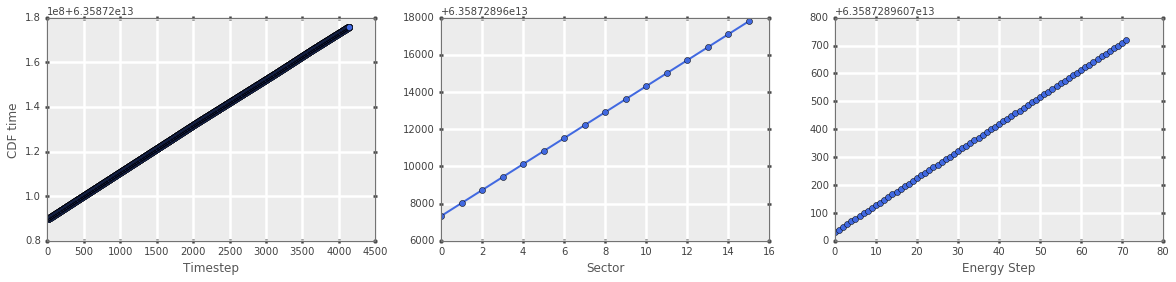

In [6]:

print('TaggedData')
TaggedData.tree(verbose=True)
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(131)
ax.plot(TaggedData['Full_times_Ele'][:,0,0], '-o', lw=2)
plt.xlabel('Timestep')
plt.ylabel('CDF time')

ax = fig.add_subplot(132)
ax.plot(TaggedData['Full_times_Ele'][0,:,0], '-o', lw=2)
plt.xlabel('Sector')

ax = fig.add_subplot(133)
ax.plot(TaggedData['Full_times_Ele'][0,0,:], '-o', lw=2)
plt.xlabel('Energy Step')



In [7]:

hope1_rot = np.matrix([[0.30432233, 0.17364818, 0.93660783],
                       [-0.05366024, 0.98480775, -0.16514923],
                       [-0.95105652, 0., 0.30901699]]).transpose()
hope2_rot = np.matrix([[0.79672621, 0.17364818, 0.57885547],
                       [-0.14048433, 0.98480775, -0.10206784],
                       [-0.58778525, 0., 0.80901699]]).transpose()
# 80 degree rotation around z
hope3_rot = np.matrix([[0.98480775, 0.17364818, 0.],
                       [-0.17364818, 0.98480775, 0.],
                       [0., 0., 1.]]).transpose()
hope4_rot = np.matrix([[0.79672621, 0.17364818, -0.57885547],
                       [-0.14048433, 0.98480775, 0.10206784],
                       [0.58778525, 0., 0.80901699]]).transpose()
hope5_rot = np.matrix([[0.30432233, 0.17364818, -0.93660783],
                       [-0.05366024, 0.98480775, 0.16514923],
                       [0.95105652, 0., 0.30901699]]).transpose()

rots = (hope1_rot, hope2_rot, hope3_rot, hope4_rot, hope5_rot)

# spin axis is omega
# compute omega in uvw
sc_uvw_rot = np.matrix([[0.81915204, -0.57357644, 0.],
                        [0.57357644, 0.81915204, 0.],
                        [-0., 0., 1.]])
# omega is along Z in xyz and uvw!!  But leave this in for tuning
omega_uvw = np.asarray((np.array([0, 0, 1]) * sc_uvw_rot))[0]



In [8]:

# long
# computePAarb(double rots[3][3],
# double magInterp[3],
# double offset[][2],
# double PA[],
# double PHI[],
# double omega[3],
# long n_values) {

lib.computePAarb.argtypes = (np.ctypeslib.ndpointer(dtype=ctypes.c_double, ndim=2, shape=(3,3), flags='C'),  # rot
                             np.ctypeslib.ndpointer(dtype=ctypes.c_double, ndim=1, shape=(3,), flags='C'),  # magInterp
                             np.ctypeslib.ndpointer(dtype=ctypes.c_double, ndim=2, flags='C'),  # offset
                             np.ctypeslib.ndpointer(dtype=ctypes.c_double, ndim=1, flags='C'),  # PA
                             np.ctypeslib.ndpointer(dtype=ctypes.c_double, ndim=1, flags='C'),  # PHI
                             np.ctypeslib.ndpointer(dtype=ctypes.c_double, ndim=1, shape=(3,), flags='C'),  # omega
                             ctypes.c_long,   # n_values
                             ctypes.c_int, # rot specification
                            )

lib.computePAarb.restype = ctypes.c_long # number of calculations



In [9]:

# PA[][N_PIXELS][N_SECTORS][N_ENERGIES],
N_TIMES = L1cdf['Elc_Cntr_e'].shape[0]
N_PIXELS = 5
N_SECTORS = 16
N_ENERGIES = 72



In [10]:

t_ind = 100 # make sure not a BS mode for testing
pixel = 3
sector = 1
energy = 32

n_polar=30
n_azi=31
polar_edges = np.linspace(-3.5,3.5,n_polar)
azi_edges = np.linspace(-4,4, n_azi)

# resp_2d(counts, polar_edges, azi_edges, fn_polar=polar_resp, fn_azi=azi_resp, to_arr=False)

fov_split = resp_2d(100, polar_edges, azi_edges, to_arr=True)

print('fov_split', fov_split.shape)
print(fov_split.min(), fov_split.max(), fov_split[:,3].min(), fov_split[:,3].max())
print('polar_edges', polar_edges.shape)
print('azi_edges', azi_edges.shape)


rot_in = np.require(rots[pixel-1],
                   dtype=ctypes.c_double,
                    requirements='C')


magInterp_in = np.require(magInterp_Ele[t_ind, sector, energy], dtype=ctypes.c_double, requirements='C')
print('magInterp_in', magInterp_in.shape)

offset_in = np.require(fov_split[:, 0:2], dtype=ctypes.c_double, requirements='C')
print('offset_in', offset_in.shape)

PA = np.empty(len(fov_split), dtype=ctypes.c_double, order='C')
PA[...] = -999
PHI = np.empty(len(fov_split), dtype=ctypes.c_double, order='C')
PHI[...] = -999

print('PA', PA.shape, 'PHI', PHI.shape)

omega_uvw_in = np.require(omega_uvw, dtype=ctypes.c_double, requirements='C')

print('omega_uvw_in', omega_uvw_in.shape)


fov_split (870, 4)
-3.86666666667 3.86666666667 4.20318950478e-05 0.00240372351237
polar_edges (30,)
azi_edges (31,)
magInterp_in (3,)
offset_in (870, 2)
PA (870,) PHI (870,)
omega_uvw_in (3,)


rot_in (3, 3)
magInterp_in (3,)
offset_in (870, 2)
PHI (870,)
omega_uvw_in (3,)
len(PA) 870
870 870


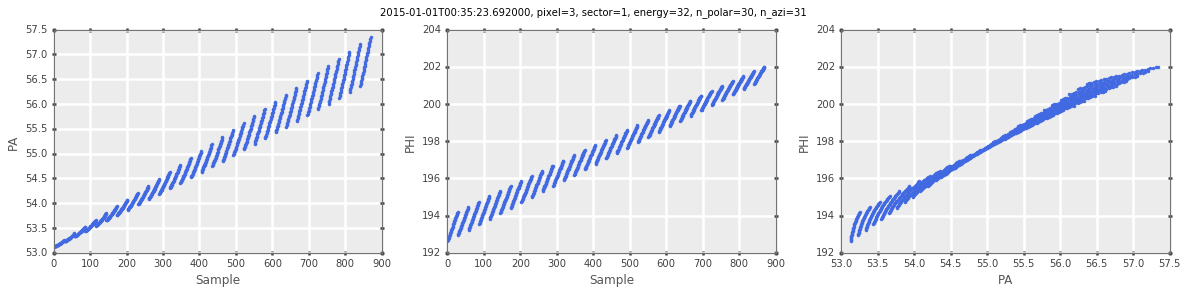

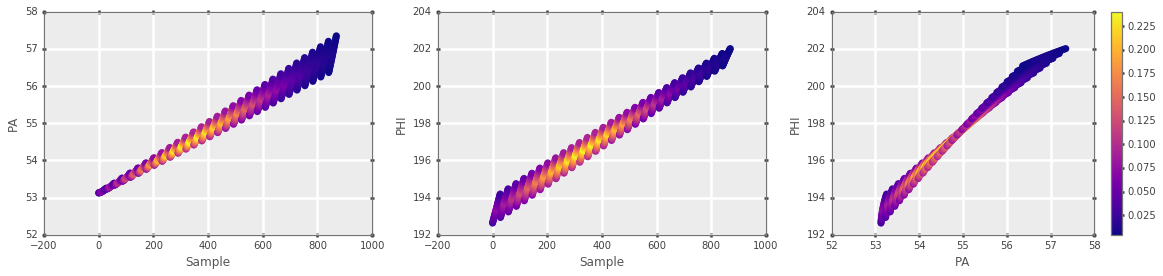

In [11]:

# long
# computePAarb(double rots[3][3],
# double magInterp[3],
# double offset[][2],
# double PA[],
# double PHI[],
# double omega[3],
# long n_values) {
print('rot_in', rot_in.shape)
print('magInterp_in', magInterp_in.shape)
print('offset_in', offset_in.shape)
print('PHI', PHI.shape)
print('omega_uvw_in', omega_uvw_in.shape)
print('len(PA)', len(PA))

n_calc = lib.computePAarb(rot_in, magInterp_in, offset_in, PA, PHI, omega_uvw_in, len(PA), 0)
print(n_calc, len(PA))


fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.plot(PA, '.')
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.plot(PHI, '.')
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
ax3.plot(PA, PHI, '.')
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')

# t_ind = 100 # make sure not a BS mode for testing
# pixel = 3
# sector = 1
# energy = 32

# n_polar=10
# n_azi=11

tm = pycdf.lib.epoch_to_datetime(TaggedData['Epoch_Ele'][t_ind])

fig.suptitle('{0}, pixel={1}, sector={2}, energy={3}, n_polar={4}, n_azi={5}'.format(tm.isoformat(), 
                                                                                     pixel, sector, energy, 
                                                                                     n_polar, n_azi))


fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.scatter(np.arange(len(PA)), PA, c=(fov_split[:,2]), s=50)
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.scatter(np.arange(len(PHI)), PHI, c=fov_split[:,2], s=50)
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
sc = ax3.scatter(PA, PHI, c=fov_split[:,2], s=50)
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')

plt.colorbar(sc)





rot_in (3, 3)
magInterp_in (3,)
offset_in (870, 2)
PHI (870,)
omega_uvw_in (3,)
len(PA) 870
870 870


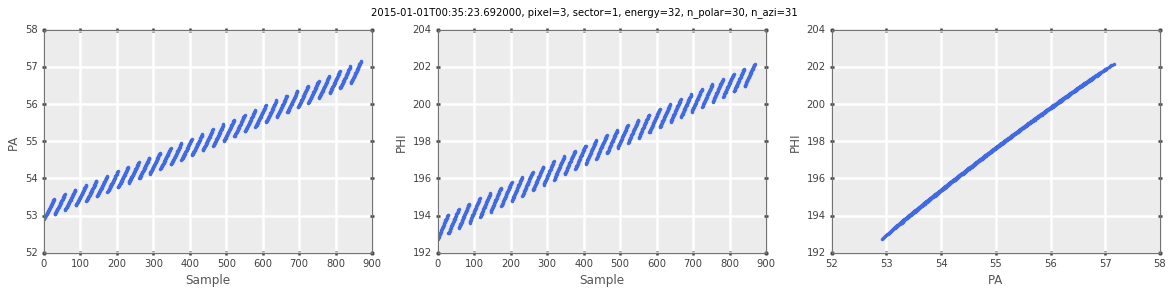

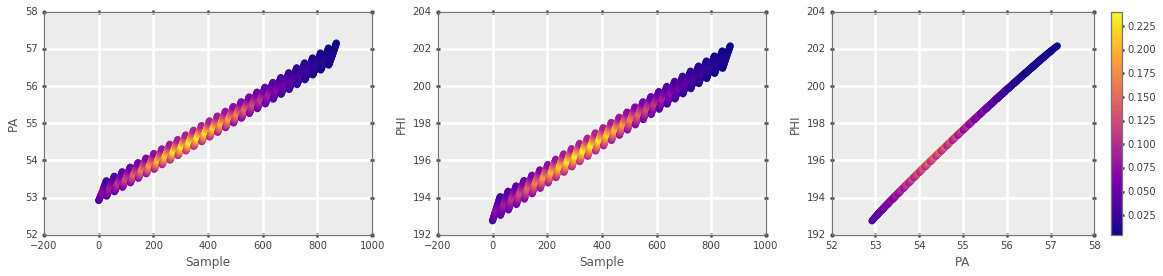

In [12]:

# long
# computePAarb(double rots[3][3],
# double magInterp[3],
# double offset[][2],
# double PA[],
# double PHI[],
# double omega[3],
# long n_values) {
print('rot_in', rot_in.shape)
print('magInterp_in', magInterp_in.shape)
print('offset_in', offset_in.shape)
print('PHI', PHI.shape)
print('omega_uvw_in', omega_uvw_in.shape)
print('len(PA)', len(PA))

n_calc = lib.computePAarb(rot_in, magInterp_in, offset_in, PA, PHI, omega_uvw_in, len(PA), 1)
print(n_calc, len(PA))


fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.plot(PA, '.')
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.plot(PHI, '.')
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
ax3.plot(PA, PHI, '.')
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')

# t_ind = 100 # make sure not a BS mode for testing
# pixel = 3
# sector = 1
# energy = 32

# n_polar=10
# n_azi=11

tm = pycdf.lib.epoch_to_datetime(TaggedData['Epoch_Ele'][t_ind])

fig.suptitle('{0}, pixel={1}, sector={2}, energy={3}, n_polar={4}, n_azi={5}'.format(tm.isoformat(), 
                                                                                     pixel, sector, energy, 
                                                                                     n_polar, n_azi))


fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.scatter(np.arange(len(PA)), PA, c=(fov_split[:,2]), s=50)
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.scatter(np.arange(len(PHI)), PHI, c=fov_split[:,2], s=50)
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
sc = ax3.scatter(PA, PHI, c=fov_split[:,2], s=50)
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')

plt.colorbar(sc)


rot_in (3, 3)
magInterp_in (3,)
offset_in (870, 2)
PHI (870,)
omega_uvw_in (3,)
len(PA) 870
870 870


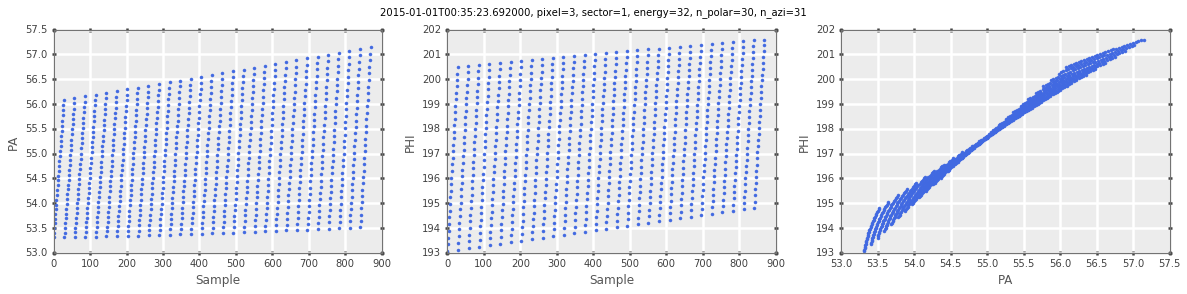

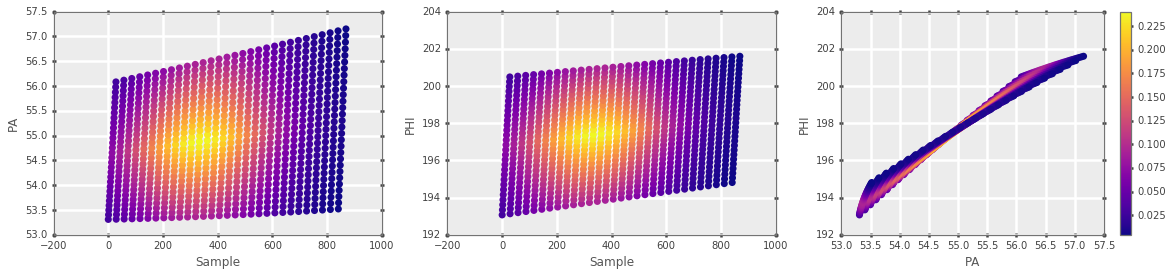

In [13]:


# long
# computePAarb(double rots[3][3],
# double magInterp[3],
# double offset[][2],
# double PA[],
# double PHI[],
# double omega[3],
# long n_values) {
print('rot_in', rot_in.shape)
print('magInterp_in', magInterp_in.shape)
print('offset_in', offset_in.shape)
print('PHI', PHI.shape)
print('omega_uvw_in', omega_uvw_in.shape)
print('len(PA)', len(PA))

n_calc = lib.computePAarb(rot_in, magInterp_in, offset_in, PA, PHI, omega_uvw_in, len(PA), 2)
print(n_calc, len(PA))


fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.plot(PA, '.')
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.plot(PHI, '.')
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
ax3.plot(PA, PHI, '.')
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')

# t_ind = 100 # make sure not a BS mode for testing
# pixel = 3
# sector = 1
# energy = 32

# n_polar=10
# n_azi=11

tm = pycdf.lib.epoch_to_datetime(TaggedData['Epoch_Ele'][t_ind])

fig.suptitle('{0}, pixel={1}, sector={2}, energy={3}, n_polar={4}, n_azi={5}'.format(tm.isoformat(), 
                                                                                     pixel, sector, energy, 
                                                                                     n_polar, n_azi))


fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.scatter(np.arange(len(PA)), PA, c=(fov_split[:,2]), s=50)
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.scatter(np.arange(len(PHI)), PHI, c=fov_split[:,2], s=50)
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
sc = ax3.scatter(PA, PHI, c=fov_split[:,2], s=50)
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')

plt.colorbar(sc)

rot_in (3, 3)
magInterp_in (3,)
offset_in (870, 2)
PHI (870,)
omega_uvw_in (3,)
len(PA) 870
870 870


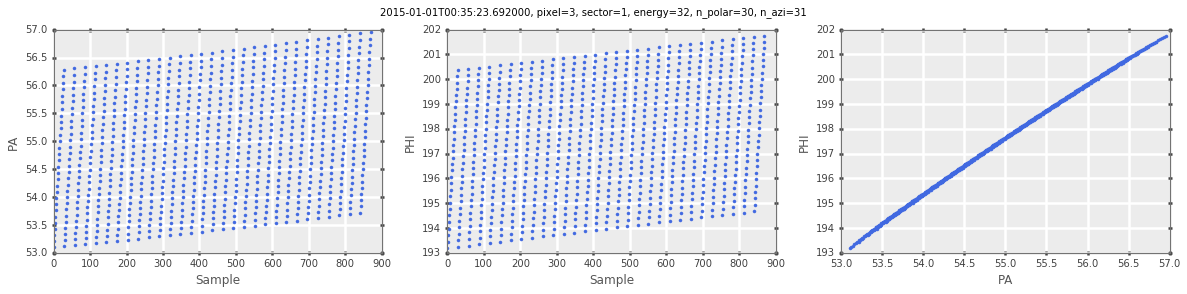

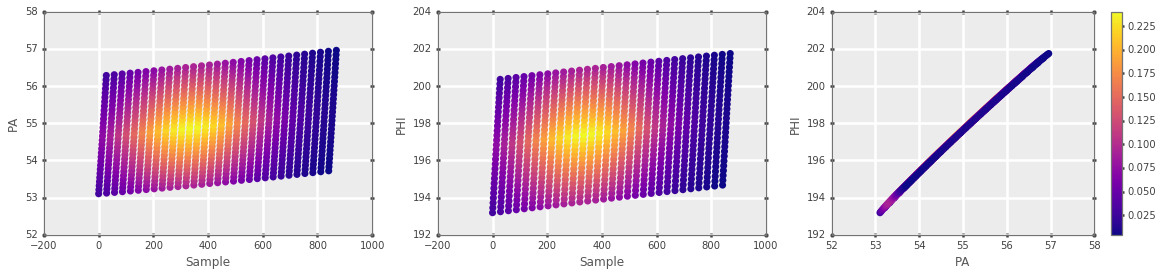

In [14]:

# long
# computePAarb(double rots[3][3],
# double magInterp[3],
# double offset[][2],
# double PA[],
# double PHI[],
# double omega[3],
# long n_values) {
print('rot_in', rot_in.shape)
print('magInterp_in', magInterp_in.shape)
print('offset_in', offset_in.shape)
print('PHI', PHI.shape)
print('omega_uvw_in', omega_uvw_in.shape)
print('len(PA)', len(PA))

n_calc = lib.computePAarb(rot_in, magInterp_in, offset_in, PA, PHI, omega_uvw_in, len(PA), 3)
print(n_calc, len(PA))


fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.plot(PA, '.')
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.plot(PHI, '.')
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
ax3.plot(PA, PHI, '.')
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')

# t_ind = 100 # make sure not a BS mode for testing
# pixel = 3
# sector = 1
# energy = 32

# n_polar=10
# n_azi=11

tm = pycdf.lib.epoch_to_datetime(TaggedData['Epoch_Ele'][t_ind])

fig.suptitle('{0}, pixel={1}, sector={2}, energy={3}, n_polar={4}, n_azi={5}'.format(tm.isoformat(), 
                                                                                     pixel, sector, energy, 
                                                                                     n_polar, n_azi))


fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.scatter(np.arange(len(PA)), PA, c=(fov_split[:,2]), s=50)
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.scatter(np.arange(len(PHI)), PHI, c=fov_split[:,2], s=50)
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
sc = ax3.scatter(PA, PHI, c=fov_split[:,2], s=50)
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')

plt.colorbar(sc)

rot_in (3, 3)
magInterp_in (3,)
offset_in (870, 2)
PHI (870,)
omega_uvw_in (3,)
len(PA) 870
870 870


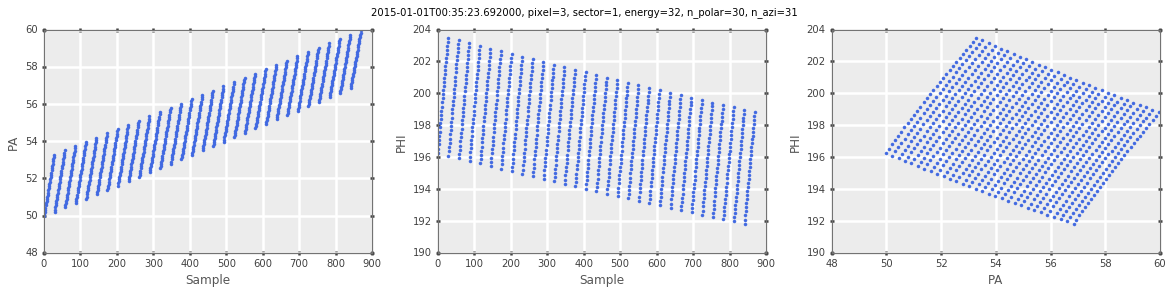

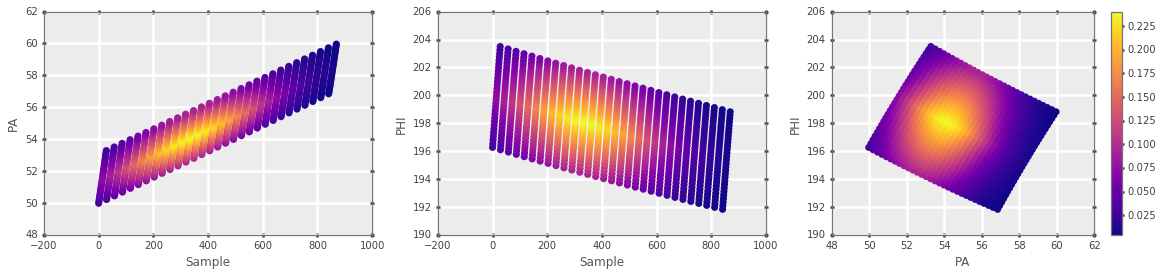

In [15]:
print('rot_in', rot_in.shape)
print('magInterp_in', magInterp_in.shape)
print('offset_in', offset_in.shape)
print('PHI', PHI.shape)
print('omega_uvw_in', omega_uvw_in.shape)
print('len(PA)', len(PA))

n_calc = lib.computePAarb(rot_in, magInterp_in, offset_in, PA, PHI, omega_uvw_in, len(PA), 4)
print(n_calc, len(PA))


fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.plot(PA, '.')
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.plot(PHI, '.')
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
ax3.plot(PA, PHI, '.')
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')

# t_ind = 100 # make sure not a BS mode for testing
# pixel = 3
# sector = 1
# energy = 32

# n_polar=10
# n_azi=11

tm = pycdf.lib.epoch_to_datetime(TaggedData['Epoch_Ele'][t_ind])

fig.suptitle('{0}, pixel={1}, sector={2}, energy={3}, n_polar={4}, n_azi={5}'.format(tm.isoformat(), 
                                                                                     pixel, sector, energy, 
                                                                                     n_polar, n_azi))


fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.scatter(np.arange(len(PA)), PA, c=(fov_split[:,2]), s=50)
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.scatter(np.arange(len(PHI)), PHI, c=fov_split[:,2], s=50)
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
sc = ax3.scatter(PA, PHI, c=fov_split[:,2], s=50)
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')

plt.colorbar(sc)

rot_in (3, 3)
magInterp_in (3,)
offset_in (870, 2)
PHI (870,)
omega_uvw_in (3,)
len(PA) 870
870 870


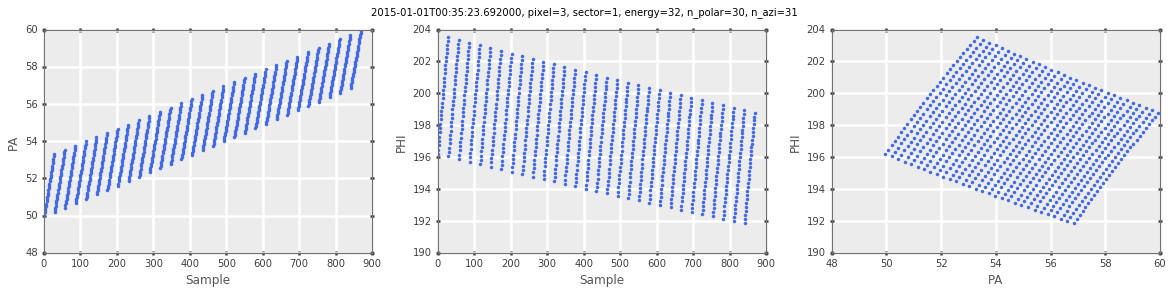

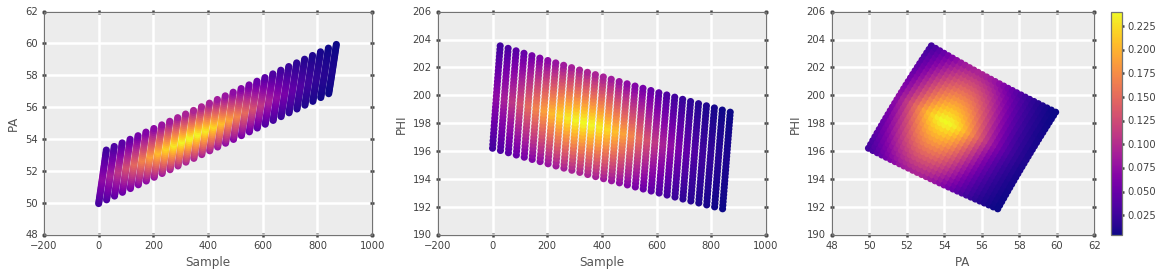

In [16]:
print('rot_in', rot_in.shape)
print('magInterp_in', magInterp_in.shape)
print('offset_in', offset_in.shape)
print('PHI', PHI.shape)
print('omega_uvw_in', omega_uvw_in.shape)
print('len(PA)', len(PA))

n_calc = lib.computePAarb(rot_in, magInterp_in, offset_in, PA, PHI, omega_uvw_in, len(PA), 5)
print(n_calc, len(PA))


fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.plot(PA, '.')
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.plot(PHI, '.')
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
ax3.plot(PA, PHI, '.')
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')

# t_ind = 100 # make sure not a BS mode for testing
# pixel = 3
# sector = 1
# energy = 32

# n_polar=10
# n_azi=11

tm = pycdf.lib.epoch_to_datetime(TaggedData['Epoch_Ele'][t_ind])

fig.suptitle('{0}, pixel={1}, sector={2}, energy={3}, n_polar={4}, n_azi={5}'.format(tm.isoformat(), 
                                                                                     pixel, sector, energy, 
                                                                                     n_polar, n_azi))


fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.scatter(np.arange(len(PA)), PA, c=(fov_split[:,2]), s=50)
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.scatter(np.arange(len(PHI)), PHI, c=fov_split[:,2], s=50)
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
sc = ax3.scatter(PA, PHI, c=fov_split[:,2], s=50)
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')

plt.colorbar(sc)

rot_in (3, 3)
magInterp_in (3,)
offset_in (870, 2)
PHI (870,)
omega_uvw_in (3,)
len(PA) 870
870 870


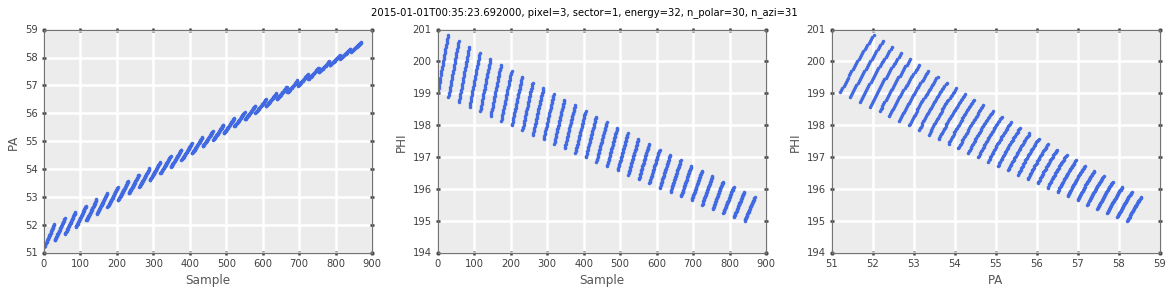

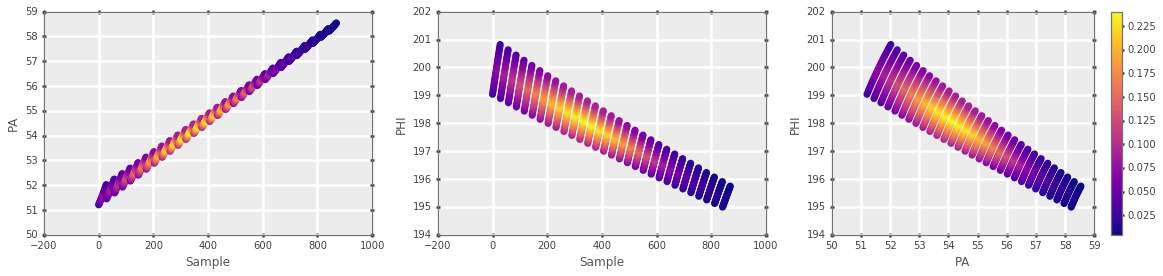

In [17]:
print('rot_in', rot_in.shape)
print('magInterp_in', magInterp_in.shape)
print('offset_in', offset_in.shape)
print('PHI', PHI.shape)
print('omega_uvw_in', omega_uvw_in.shape)
print('len(PA)', len(PA))

n_calc = lib.computePAarb(rot_in, magInterp_in, offset_in, PA, PHI, omega_uvw_in, len(PA), 6)
print(n_calc, len(PA))


fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.plot(PA, '.')
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.plot(PHI, '.')
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
ax3.plot(PA, PHI, '.')
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')

# t_ind = 100 # make sure not a BS mode for testing
# pixel = 3
# sector = 1
# energy = 32

# n_polar=10
# n_azi=11

tm = pycdf.lib.epoch_to_datetime(TaggedData['Epoch_Ele'][t_ind])

fig.suptitle('{0}, pixel={1}, sector={2}, energy={3}, n_polar={4}, n_azi={5}'.format(tm.isoformat(), 
                                                                                     pixel, sector, energy, 
                                                                                     n_polar, n_azi))


fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.scatter(np.arange(len(PA)), PA, c=(fov_split[:,2]), s=50)
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.scatter(np.arange(len(PHI)), PHI, c=fov_split[:,2], s=50)
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
sc = ax3.scatter(PA, PHI, c=fov_split[:,2], s=50)
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')

plt.colorbar(sc)

rot_in (3, 3)
magInterp_in (3,)
offset_in (870, 2)
PHI (870,)
omega_uvw_in (3,)
len(PA) 870
870 870


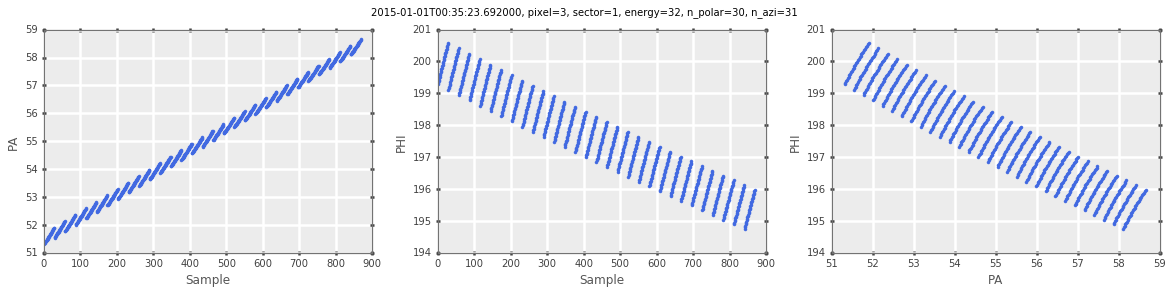

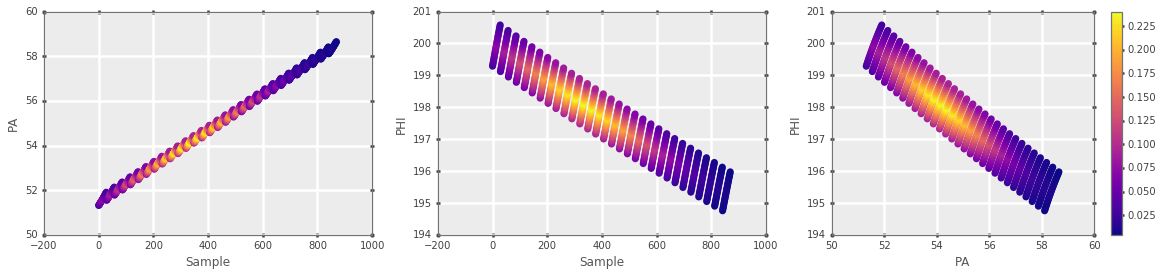

In [18]:
print('rot_in', rot_in.shape)
print('magInterp_in', magInterp_in.shape)
print('offset_in', offset_in.shape)
print('PHI', PHI.shape)
print('omega_uvw_in', omega_uvw_in.shape)
print('len(PA)', len(PA))

n_calc = lib.computePAarb(rot_in, magInterp_in, offset_in, PA, PHI, omega_uvw_in, len(PA), 7)
print(n_calc, len(PA))


fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.plot(PA, '.')
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.plot(PHI, '.')
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
ax3.plot(PA, PHI, '.')
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')

# t_ind = 100 # make sure not a BS mode for testing
# pixel = 3
# sector = 1
# energy = 32

# n_polar=10
# n_azi=11

tm = pycdf.lib.epoch_to_datetime(TaggedData['Epoch_Ele'][t_ind])

fig.suptitle('{0}, pixel={1}, sector={2}, energy={3}, n_polar={4}, n_azi={5}'.format(tm.isoformat(), 
                                                                                     pixel, sector, energy, 
                                                                                     n_polar, n_azi))


fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.scatter(np.arange(len(PA)), PA, c=(fov_split[:,2]), s=50)
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.scatter(np.arange(len(PHI)), PHI, c=fov_split[:,2], s=50)
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
sc = ax3.scatter(PA, PHI, c=fov_split[:,2], s=50)
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')

plt.colorbar(sc)

#  So it looks like #5 and #4 are the correct ones, are they the same?

rot_in (3, 3)
magInterp_in (3,)
offset_in (870, 2)
PHI (870,)
omega_uvw_in (3,)
len(PA) 870
870 870
(0.999, 1.0029999999999999)


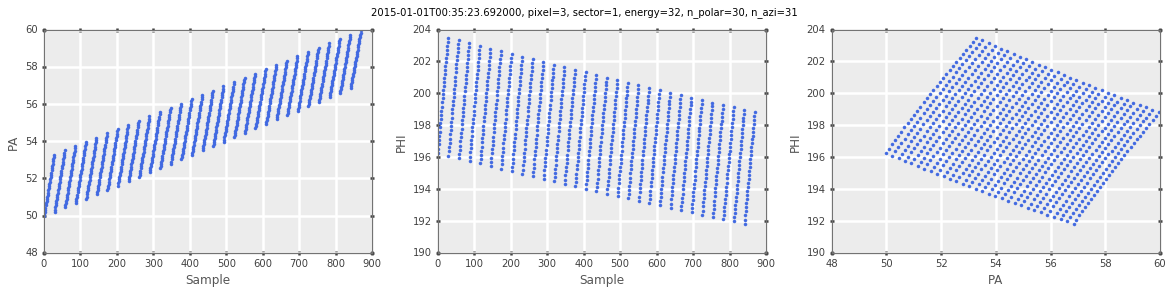

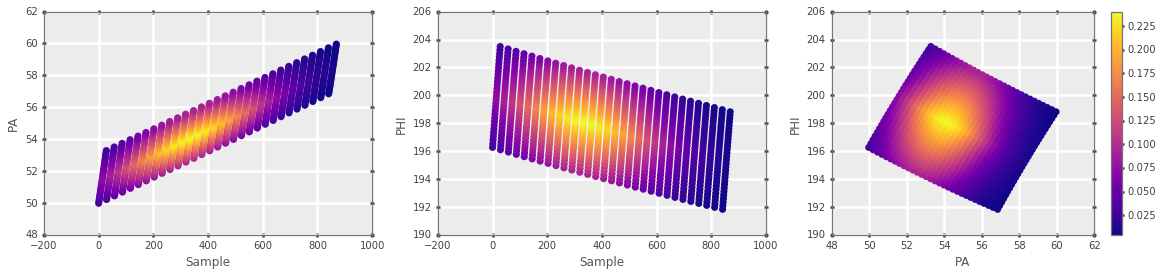

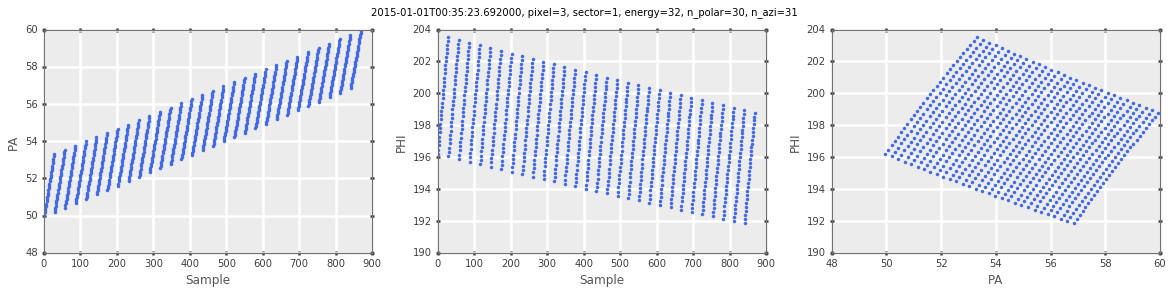

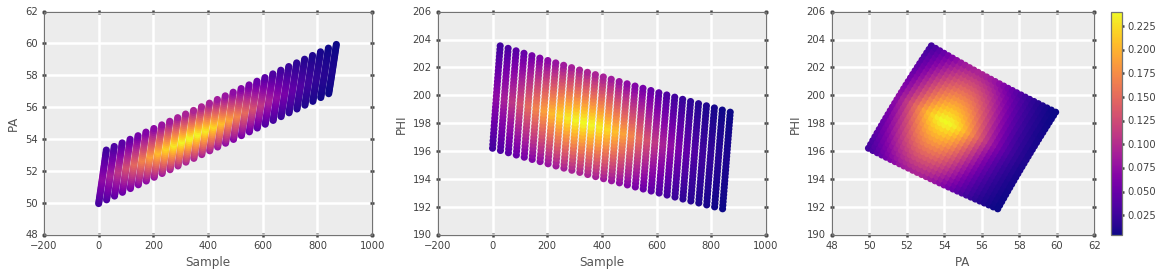

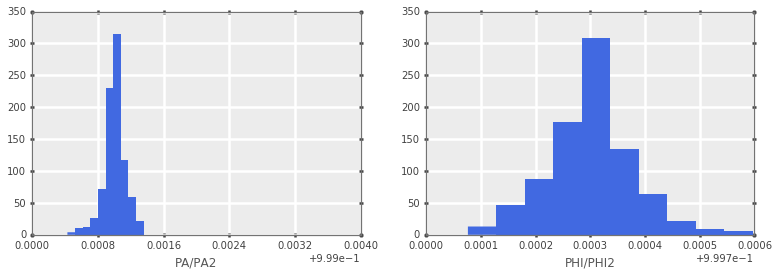

In [19]:

n_calc = lib.computePAarb(rot_in, magInterp_in, offset_in, PA, PHI, omega_uvw_in, len(PA), 4)

fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.plot(PA, '.')
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.plot(PHI, '.')
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
ax3.plot(PA, PHI, '.')
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')

tm = pycdf.lib.epoch_to_datetime(TaggedData['Epoch_Ele'][t_ind])

fig.suptitle('{0}, pixel={1}, sector={2}, energy={3}, n_polar={4}, n_azi={5}'.format(tm.isoformat(), 
                                                                                     pixel, sector, energy, 
                                                                                     n_polar, n_azi))


fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.scatter(np.arange(len(PA)), PA, c=(fov_split[:,2]), s=50)
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.scatter(np.arange(len(PHI)), PHI, c=fov_split[:,2], s=50)
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
sc = ax3.scatter(PA, PHI, c=fov_split[:,2], s=50)
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')

plt.colorbar(sc)

print('rot_in', rot_in.shape)
print('magInterp_in', magInterp_in.shape)
print('offset_in', offset_in.shape)
print('PHI', PHI.shape)
print('omega_uvw_in', omega_uvw_in.shape)
print('len(PA)', len(PA))

PA2 = np.zeros_like(PA)
PHI2 = np.zeros_like(PHI)


n_calc = lib.computePAarb(rot_in, magInterp_in, offset_in, PA2, PHI2, omega_uvw_in, len(PA), 5)
print(n_calc, len(PA))


fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.plot(PA2, '.')
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.plot(PHI2, '.')
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
ax3.plot(PA2, PHI2, '.')
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')


tm = pycdf.lib.epoch_to_datetime(TaggedData['Epoch_Ele'][t_ind])

fig.suptitle('{0}, pixel={1}, sector={2}, energy={3}, n_polar={4}, n_azi={5}'.format(tm.isoformat(), 
                                                                                     pixel, sector, energy, 
                                                                                     n_polar, n_azi))


fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.scatter(np.arange(len(PA2)), PA2, c=(fov_split[:,2]), s=50)
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.scatter(np.arange(len(PHI2)), PHI2, c=fov_split[:,2], s=50)
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
sc = ax3.scatter(PA2, PHI2, c=fov_split[:,2], s=50)
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')

plt.colorbar(sc)

# make a ratio
fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.hist(PA/PA2)
ax1.set_xlabel('PA/PA2')
ax1.set_xticks(np.linspace(0.999, 1.003, 6))
print( ax1.get_xlim())

ax2 = fig.add_subplot(132)
ax2.hist(PHI/PHI2)
ax2.set_xlabel('PHI/PHI2')
# ax2.set_xticks(np.linspace(0,1, 100))



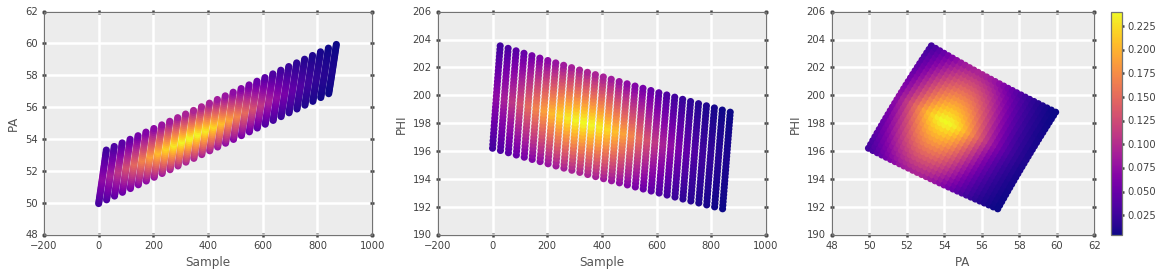

In [24]:

fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.scatter(np.arange(len(PA2)), PA2, c=(fov_split[:,2]), s=50)
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.scatter(np.arange(len(PHI2)), PHI2, c=fov_split[:,2], s=50)
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
sc = ax3.scatter(PA2, PHI2, c=fov_split[:,2], s=50)
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')

plt.colorbar(sc)
